# RNNs for Text Classification

We will use a RNN based model to perform classification of SMS messages into Spam or not Spam. The notebook has split the entire process into several parts for your convienience. To appreciate preprocessing in music, it is important to understand preprocessing in other domains. You may need to read up upon tokenization, embeddings (Glove) and Dataloaders, as well as how to pipeline an end - to - end AI model

**Resources:** \
https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/

We do not expect you to finish the code entirely, take help whenever required, but understand the code you have written, do not blindly copy code. In case of help required at any time, feel free to contact the project leads.

| Name | Phone Number |
| :-- | :-- |
| Pranay Mathur | 7032832559|
| Swathi Narashiman | 6379869509 |

In [ ]:
# Imports
from IPython.display import clear_output
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import spacy
import re
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Downloading the Spam SMS Dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

!unzip /content/smsspamcollection.zip
!rm /content/readme
!rm !rm /content/smsspamcollection.zip

clear_output()

In [ ]:
# Downloading the GloVe embeddings database

!wget https://nlp.stanford.edu/data/glove.6B.zip

!unzip /content/glove.6B.zip

!rm -rf /content/glove.6B.zip
!rm /content/glove.6B.100d.txt
!rm /content/glove.6B.200d.txt
!rm /content/glove.6B.300d.txt

clear_output()

In [ ]:
text = []
label = []
data = []

with open("/content/SMSSpamCollection") as f:

    """ read each line of the text file and create a Pandas Data Frame
        label spam messages as 1 and legit messages as 0
    """
    for line in f:
        data = line.partition('\t')
        a,b,c = data
        text.append(c)
        if a == "spam":
          label.append(1)
        else:
          label.append(0)





    ###########YOUR CODE HERE###########

In [ ]:
sms.shape

(5574, 5)

In [ ]:
# Creating a Pandas Dataframe
sms = pd.DataFrame(zip(text, label), columns = ["Text", "Label"])

sms['Text_Length'] = sms['Text'].apply(lambda x: len(x))
sms.sample()

,Text,Label,Text_Length
1629,Yes princess! I want to make you happy...\n,0,42


In [ ]:
sms.tail()

,Text,Label,Text_Length
5569,This is the 2nd time we have tried 2 contact u...,1,161
5570,Will ü b going to esplanade fr home?\n,0,37
5571,"Pity, * was in mood for that. So...any other s...",0,58
5572,The guy did some bitching but I acted like i'd...,0,126
5573,Rofl. Its true to its name\n,0,27


In [ ]:
spacy_tokenizer = spacy.load('en_core_web_sm')
def tokenize (text):

    """remove any non-ascii characters
       remove punctuations
       tokenize the text
       return the tokenized text
    """
    doc = spacy_tokenizer(text)

    # Remove non-ASCII characters and punctuation
    tokens = []
    for token in doc:
      if token.is_ascii and not token.is_punct:
        tokens.append(token.text)
    return tokens

    ###########YOUR CODE HERE###########

In [ ]:
# Tokenize the text sms in the Pandas Dataframe
sms["Tokenized_Text"] = sms['Text'].apply(tokenize)

In [ ]:
def load_GloVe_embeddings(glove_file):

    """
        load the GloVe embeddings from the files downloaded
        create a dictionary of the form {word : word embedding}
    """




    embeddings_dict = {}

    # Open the file and read each line
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:

            values = line.split()
            word = values[0]


            embedding = []
            for val in values[1:]:
                embedding.append(float(val))

            embeddings_dict[word] = embedding

    return embeddings_dict

glove_file_path = 'glove.6B.50d.txt'
glove_embeddings = load_GloVe_embeddings(glove_file_path)
print("Embedding for 'hello':", glove_embeddings['hello'])

Embedding for 'hello': [-0.38497, 0.80092, 0.064106, -0.28355, -0.026759, -0.34532, -0.64253, -0.11729, -0.33257, 0.55243, -0.087813, 0.9035, 0.47102, 0.56657, 0.6985, -0.35229, -0.86542, 0.90573, 0.03576, -0.071705, -0.12327, 0.54923, 0.47005, 0.35572, 1.2611, -0.67581, -0.94983, 0.68666, 0.3871, -1.3492, 0.63512, 0.46416, -0.48814, 0.83827, -0.9246, -0.33722, 0.53741, -1.0616, -0.081403, -0.67111, 0.30923, -0.3923, -0.55002, -0.68827, 0.58049, -0.11626, 0.013139, -0.57654, 0.048833, 0.67204]


In [ ]:
def embed_text(tokenized_text, word_embeddings, max_text_length=20, embedding_size = 50):
    """
        given a sequence of tokens convert them to their word embeddings
    """
    embedded_text = np.zeros((max_text_length, embedding_size), dtype=np.float32)
    for i, token in enumerate(tokenized_text[:max_text_length]):
        if token in word_embeddings:
            embedded_text[i] = word_embeddings[token]
        else:
            # If the token is not found in word embeddings, use a random embedding
            embedded_text[i] = np.random.normal(scale=0.6, size=(embedding_size,))
    return embedded_text

    ###########YOUR CODE HERE###########

In [ ]:
sms["Embedded_Text"] = sms["Text"].apply(lambda tokens: embed_text(tokens, glove_embeddings))

In [ ]:
print(torch.tensor(sms['Embedded_Text']).shape)

torch.Size([5574, 20, 50])


In [ ]:
class load_dataset(Dataset):
    def __init__(self, X, Y):
        """
        X: the embeddings of the sentence
        Y: ground truth of the sentence (0- positive, 1- negative)
        """
        self.X = X
        self.y = Y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = {'X': torch.tensor(self.X[idx]), 'y': self.y[idx]}
        return (torch.tensor(self.X[idx]), self.y[idx])


In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim=50, hidden_size=25, num_layers=2, dropout_p=0.1):
        """
        Define your layers, activation functions here:
        - vocab_size: Size of the vocabulary
        - embedding_dim: Dimensionality of the word embeddings
        - hidden_size: Dimensionality of the hidden state
        - num_layers: Number of RNN layers
        """
        super(RNN, self).__init__()

        # RNN Layer
        self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first = True)

        # Output Layer
        self.fc = nn.Linear(hidden_size, 1)  # Output layer with 1 output unit

        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_p)



    def forward(self, x):
        """
        Perform a forward pass:
        - x: Input sequence of word indices
        """
        # Embed the input sequence
        # ... (Your embedding layer implementation)

        # Pass through RNN layers
        last_hidden, hidden = self.rnn(x)



        # Apply linear transformation and activation
        out = self.fc(last_hidden)


        out = self.activation(out)


        # Apply sigmoid activation function
        averages = torch.mean(out, dim=1)



# Thresholding

# Convert the tensor to a 1D tensor of length 32 by collapsing the first dimension


        return averages.squeeze()

In [ ]:
import matplotlib.pyplot as plt

def train_model(num_epochs, train_loader, model, criterion, optimizer):
    """
    Train the RNN model for a specified number of epochs.

    Args:
        num_epochs: Number of training epochs.
        train_loader: PyTorch DataLoader for the training data.
        model: The RNN model instance.
        criterion: Loss function (e.g., nn.BCELoss for binary classification).
        optimizer: Optimizer (e.g., Adam) for updating model parameters.
    """
    losses = []  # To store the training losses for each epoch

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Initialize running loss and correct predictions
        running_loss = 0.0
        correct_predictions = 0

        # Set the model to training mode
        model.train()

        # Iterate over batches in the training data
        for data, target in train_loader:
            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)

            # Calculate loss
            loss = criterion(outputs, target.float())

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

            # Calculate the number of correct predictions
            predicted_labels = (outputs >= 0.5).float()  # Thresholding at 0.5
            correct_predictions += (predicted_labels == target.float()).sum().item()

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions / len(train_loader.dataset)

        # Append the loss for this epoch
        losses.append(epoch_loss)

        # Print training statistics
        print(f"Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Plot the training loss across epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Epoch')
    plt.show()

In [ ]:
import torch

from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_accuracy(test_loader, model, criterion):
    """
    Evaluate the accuracy of the model on the test data and plot loss vs. epoch graph.

    Args:
        test_loader: PyTorch DataLoader for the testing data.
        model: The RNN model instance.
        criterion: Loss function (e.g., nn.BCELoss for binary classification).

    Returns:
        Accuracy (float): The accuracy of the model on the test data.
    """
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    testing_losses = []
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target.float())
            testing_losses.append(loss.item())

            predicted_label = torch.round(outputs)  # Assuming binary classification
            predicted_labels.extend(predicted_label.tolist())
            true_labels.extend(target.tolist())

            correct_predictions += (predicted_label == target).sum().item()
            total_predictions += len(target)

    accuracy = correct_predictions / total_predictions



    # Print confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy


In [ ]:
sms.sample()

,Text,Label,Text_Length,Tokenized_Text,Embedded_Text
2646,"Sorry, I'll call later\n",0,23,"[Sorry, I, 'll, call, later, \n]","[[0.44143865, -0.022081846, -0.30445778, 1.058..."


In [ ]:
#dataset_iter = iter(dataset)

#next(dataset)
dataset[0][0].shape

torch.Size([20, 50])

Epoch 1/10
Training Loss: 0.3970, Accuracy: 0.8645
Epoch 2/10
Training Loss: 0.3333, Accuracy: 0.8820
Epoch 3/10
Training Loss: 0.2900, Accuracy: 0.8962
Epoch 4/10
Training Loss: 0.2651, Accuracy: 0.8991
Epoch 5/10
Training Loss: 0.2414, Accuracy: 0.9029
Epoch 6/10
Training Loss: 0.2184, Accuracy: 0.9152
Epoch 7/10
Training Loss: 0.1920, Accuracy: 0.9222
Epoch 8/10
Training Loss: 0.1685, Accuracy: 0.9312
Epoch 9/10
Training Loss: 0.1587, Accuracy: 0.9394
Epoch 10/10
Training Loss: 0.1811, Accuracy: 0.9264


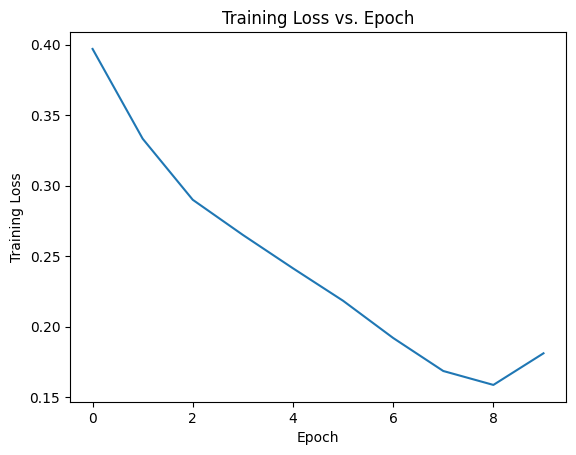

In [ ]:
import torch
from torch.utils.data import DataLoader

# Assuming you have already defined the functions:
# - load_dataset(X, Y)
# - RNN(vocab_size, embedding_dim, hidden_size, num_layers)
# - train_model(num_epochs, train_loader, model, criterion, optimizer)
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# 1. Data Splitting
# Assuming your data is stored in X and y
dataset = load_dataset(sms['Embedded_Text'], sms['Label'])

# Splitting the dataset
train_size, test_size = int(0.8 * len(dataset)), len(dataset) - int(0.8*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Model Definition
vocab_size = 20
embedding_dim = 50  # Embedding dimension
hidden_size = 16  # Hidden state dimension
num_layers = 2  # Number of RNN layers
model = RNN(vocab_size, embedding_dim, hidden_size, num_layers)

# 3. Hyperparameter Setup
learning_rate = 0.01  # Learning rate
num_epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

# 4. Train the Model
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train_dataset = load_dataset(X_train, y_train)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_model(num_epochs, train_loader, model, criterion, optimizer)

# 5. Evaluate Model Accuracy
# Assuming you have a function to evaluate accuracy

#test_dataset = load_dataset(X_test, y_test)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




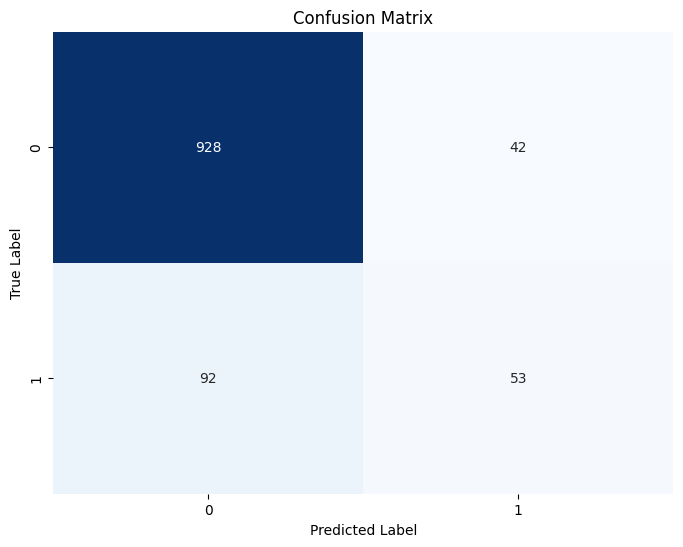

Test Accuracy: 0.8798


In [ ]:

accuracy = evaluate_accuracy(test_loader,model,criterion)  # Replace with your evaluation function
print(f"Test Accuracy: {accuracy:.4f}")



In [ ]:
# 6. Save the Model
torch.save(model.state_dict(), "sentiment_model.pth")